### Simulation (SPN)
- 3 종류의 파라미터 세트로 실험 진행 
    - Untangling Basal Ganglia Network Dynamics and Function
        - 시간에 따라 I를 바꿔가며 입력 
    - Action selection in the rhythmic brain: The role of the basal ganglia and tremor
    - Quantifying harmony between direct and indirect pathways in the basal ganglia: healthy and Parkinsonian state

In [1]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


In [2]:
# Neuron parameters (Set 1)
# eNeuro

a = 0.2 / br.ms
b = 0.025 / br.ms
c = -60 * br.mV
d = 0 * br.mV / br.ms
vpeak = 25 * br.mV
vr = -64.4 * mV
vt = -50 * br.mV
C = 80 * br.pF 

v = 0 * br.mV
u = 0.0 * br.mV
K = 1

L = 0.331
Ispon = 0.0 * br.mV
KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014
N = 10000

In [5]:
# Neuron parameters (Set 2)
# Fountas, Zafeirios. "Action selection in the rhythmic brain: The role of the basal ganglia and tremor." PhD Thesis, Imperial College London (2016).

a = 0.01 / br.ms
b = -20 / br.ms
c = -55 * br.mV
d = 91 * br.mV / br.ms
vpeak = 40 * br.mV
vr = -80 * mV
vt = -29.7 * br.mV
C = 15.2 * br.pF 
v = -80 * br.mV
u = 0.0 * br.mV
Ispon = 0.0 * br.mV
K = 0.0289
L = 0.331

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014
        
sigma_msn = 14.0 * br.mV
N = 10000

In [21]:
### input from cortex (Set 3)

def generate_cortex_input(duration, dt):
    t = np.arange(0, duration, dt)  # 시간 배열 생성
    input_values = np.ones_like(t) * 20  # 기본 값으로 초기화
    
    spike_time = 50 
    spike_duration = 20
    spike_value = 90

    spike_indices = np.logical_or(t >= spike_time, t < spike_time + spike_duration)
    for i in range(min(spike_time, len(input_values)), min(spike_time + spike_duration, len(input_values))):
        input_values[i] = spike_value
            
    return t * ms, input_values

dt = 0.1
defaultclock.dt = 1 * ms  # 시뮬레이션 시간 단계 설정
duration = 10000 * ms  # 시뮬레이션 시간 설정
t, cortex_input = generate_cortex_input(duration, defaultclock.dt)
input_array = TimedArray(cortex_input, dt=dt*ms)

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wct5a1x3
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

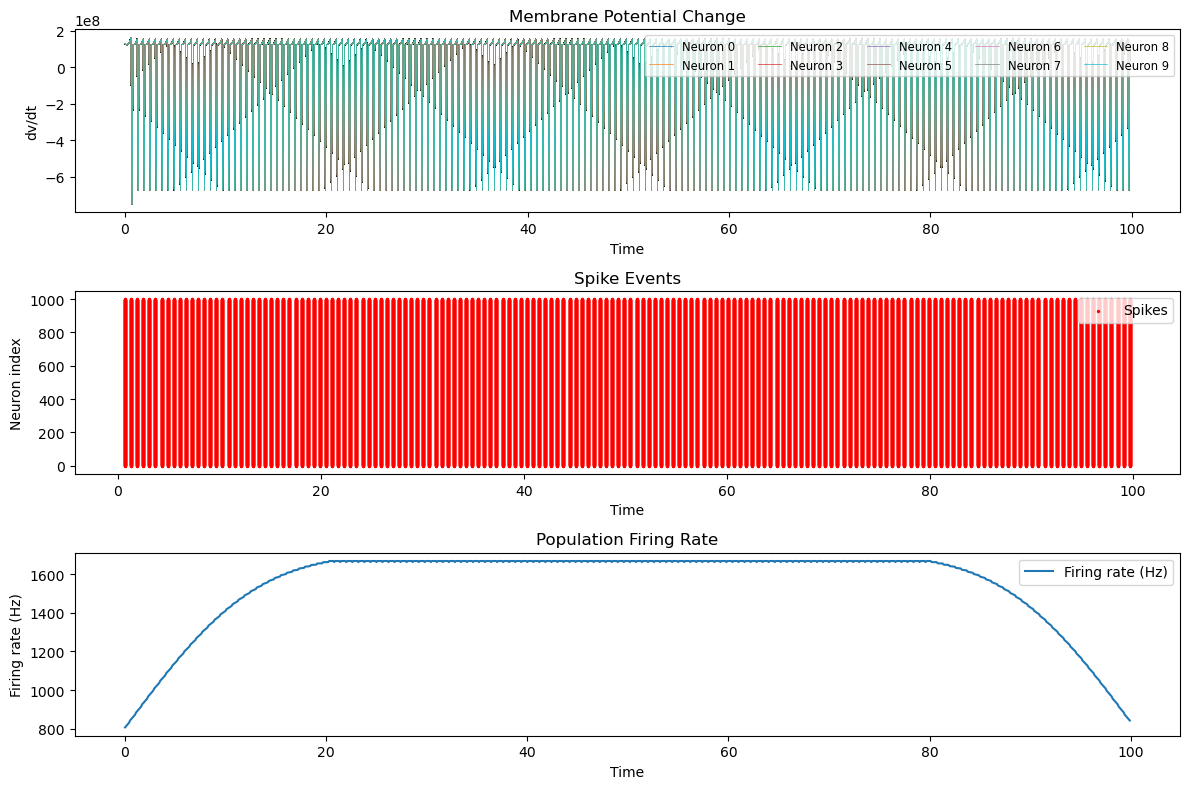

In [3]:
### Set 1: Untangling Basal Ganglia Network Dynamics and Function

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()

WARNING    'a' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 200. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 25. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'vr' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the val

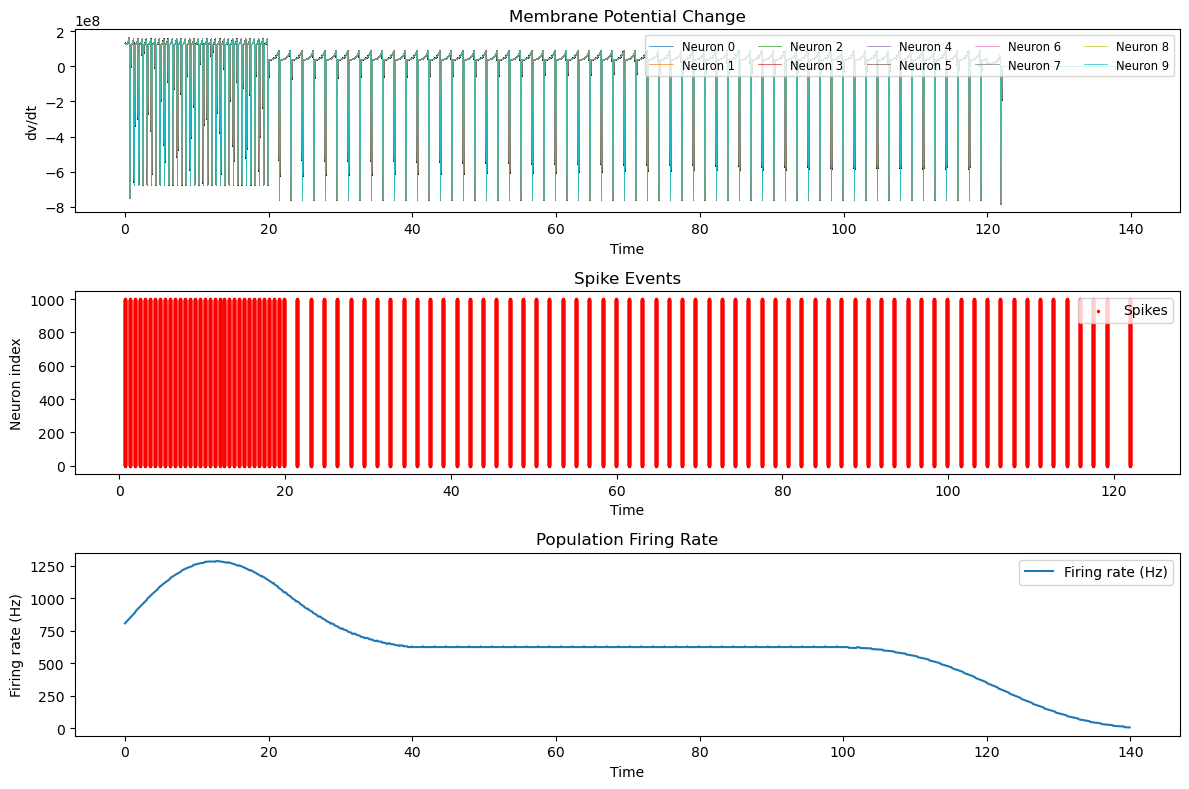

In [4]:
### Set 1: Untangling Basal Ganglia Network Dynamics and Function
# simulation 하는 과정에서 I 값을 10, 3, 0으로 줄여가며 실험 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)

# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
dSPN.I = 10*nA
run(20 * ms)
dSPN.I = 3*nA
run(100 * ms)
dSPN.I = 0*nA
run(20 * ms)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()

WARNING    'a' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -20. * khertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'vr' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'vt' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value

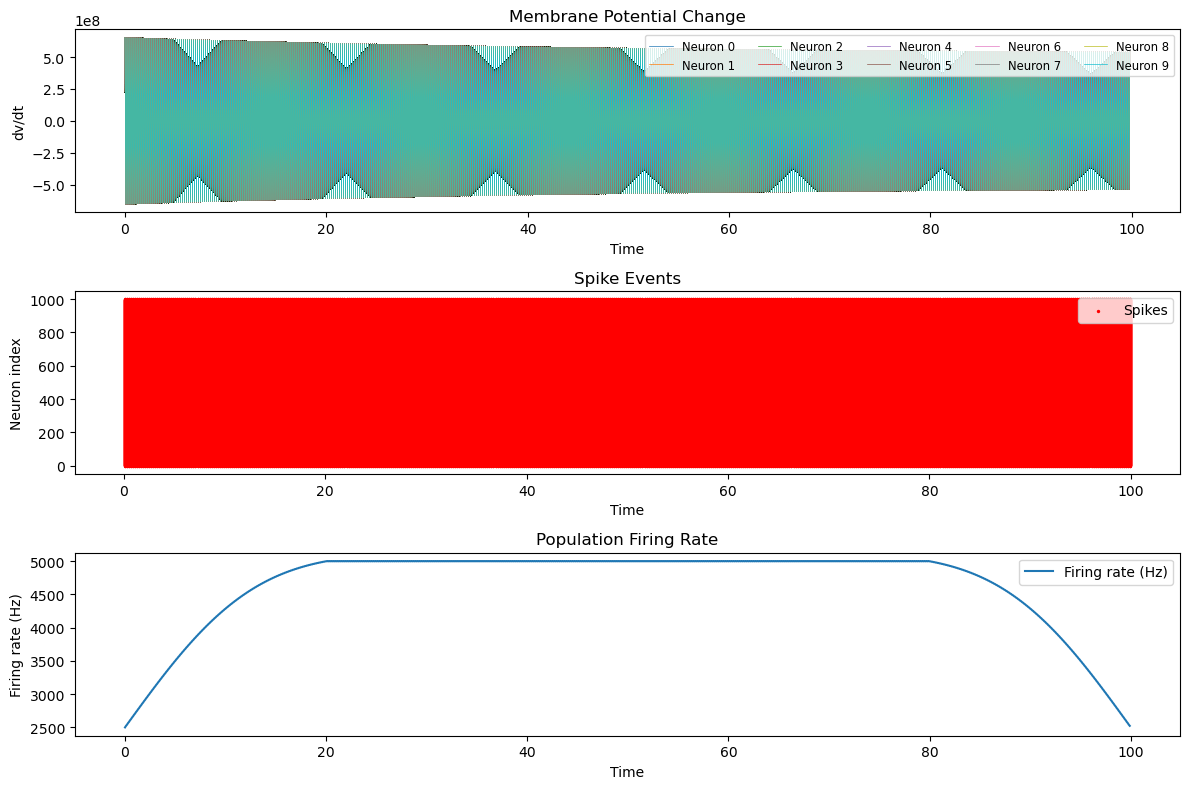

In [6]:
# Set 2

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -65 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.02 / ms
dSPN.b = 0.2 / ms
dSPN.c = -65 * mV
dSPN.d = 8 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 30 * mV
dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)

# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
run(100 * ms)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()

WARNING    'a' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 10. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -20. * khertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'vr' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'vt' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with

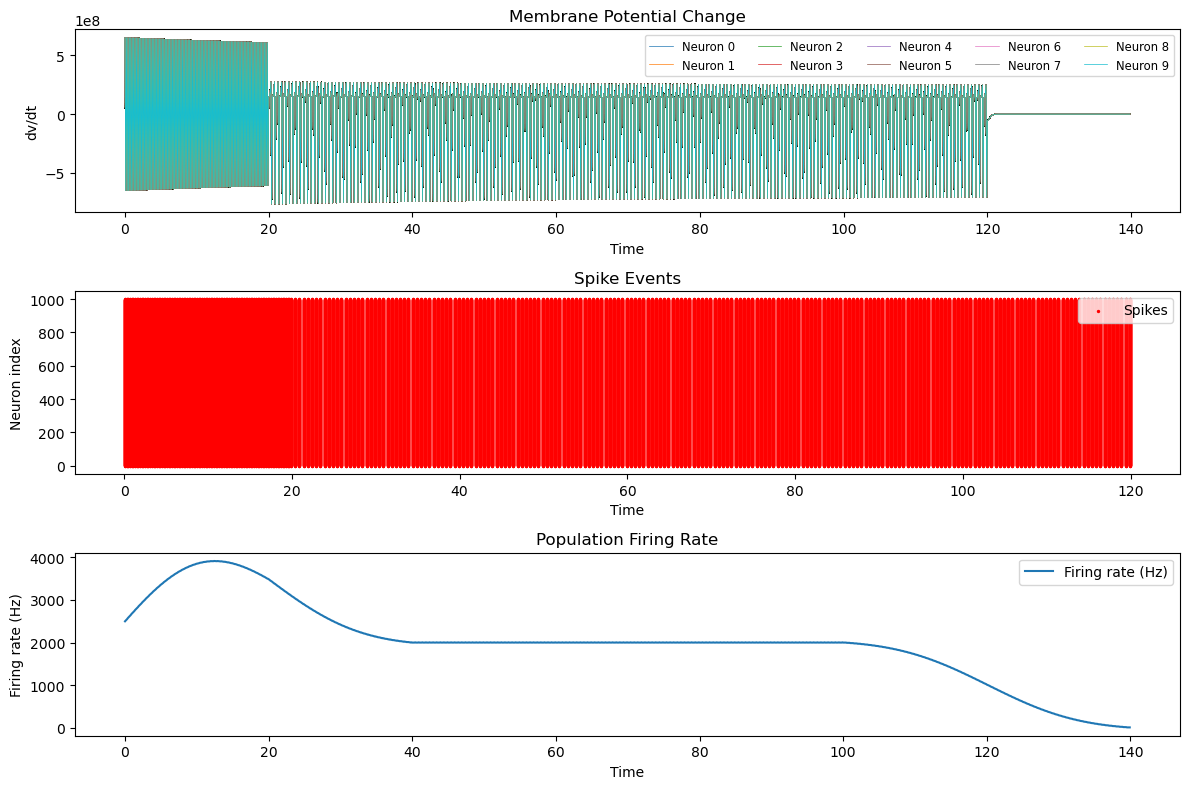

In [7]:
### Set 2
# simulation 하는 과정에서 I 값을 10, 3, 0으로 줄여가며 실험 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -65 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.02 / ms
dSPN.b = 0.2 / ms
dSPN.c = -65 * mV
dSPN.d = 8 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 30 * mV
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
dSPN.I = 10*nA
run(20 * ms)
dSPN.I = 3*nA
run(100 * ms)
dSPN.I = 0*nA
run(20 * ms)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()

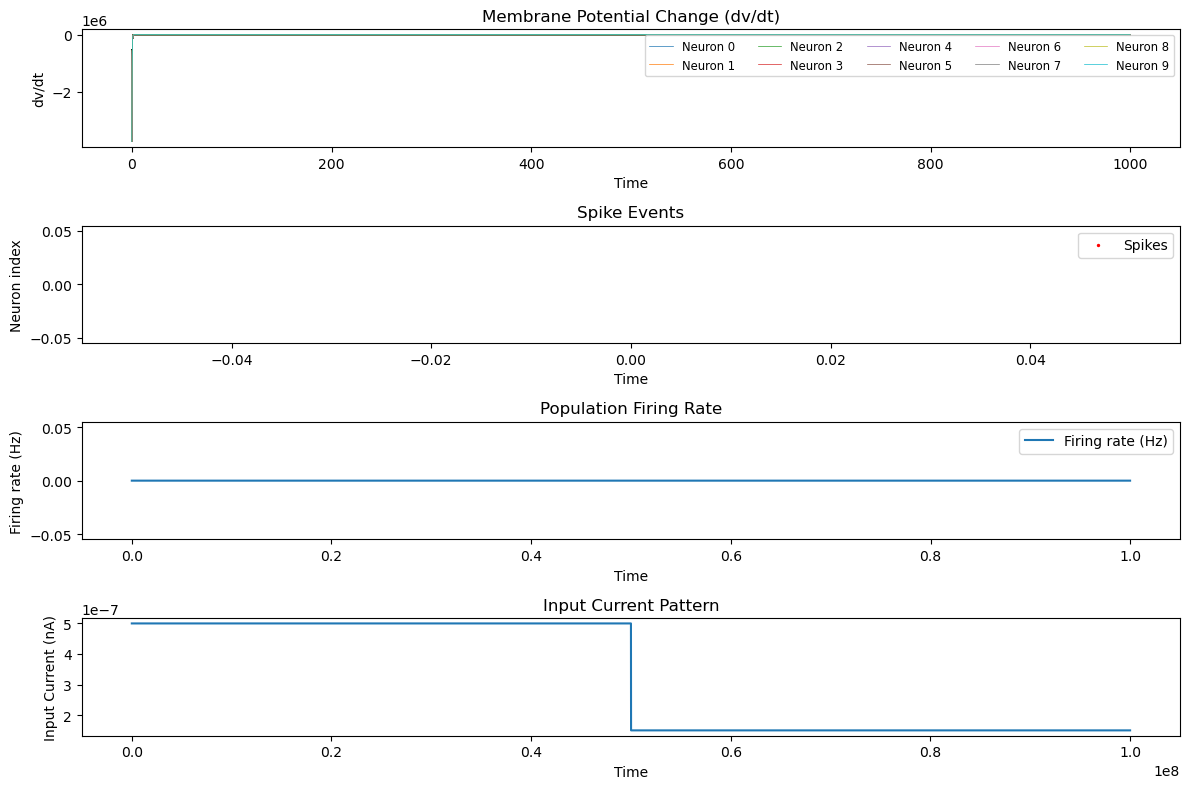

In [8]:
### Set 2
# add cortex input (초기 I: 500 * nA)

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 1000 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

# dSPN.run_regularly('v = rand()', dt = 1 * ms)
# Create input pattern: constant then step change
I_base = 500 * nA
I_step = 150 * nA
I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                   I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA
I_pattern = TimedArray(I_pattern_values, dt=defaultclock.dt)

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.01 / br.ms
dSPN.b = -20 / ms
# dSPN.c = -55 * mV
dSPN.d = 91 * mV / ms
dSPN.k = 1
dSPN.vr = -80 * mV
dSPN.vt = -29.7 * mV
dSPN.vpeak = 40 * mV
C = 15.2 * pF
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5
dSPN.run_regularly('I = I_pattern(t)', dt=defaultclock.dt)

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(4, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

# Plot input current pattern
plt.subplot(4, 1, 4)
input_times = np.arange(len(I_pattern_values)) * defaultclock.dt / ms
plt.plot(input_times, I_pattern_values / nA)
plt.xlabel('Time')
plt.ylabel('Input Current (nA)')
plt.title('Input Current Pattern')

plt.tight_layout()
plt.show()

INFO:root:building '_cython_magic_9da06036d13a4eddec5174626e1de3c0' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_9da06036d13a4eddec5174626e1de3c0.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_9da06036d13a4eddec5174626e1de3c0.o -w

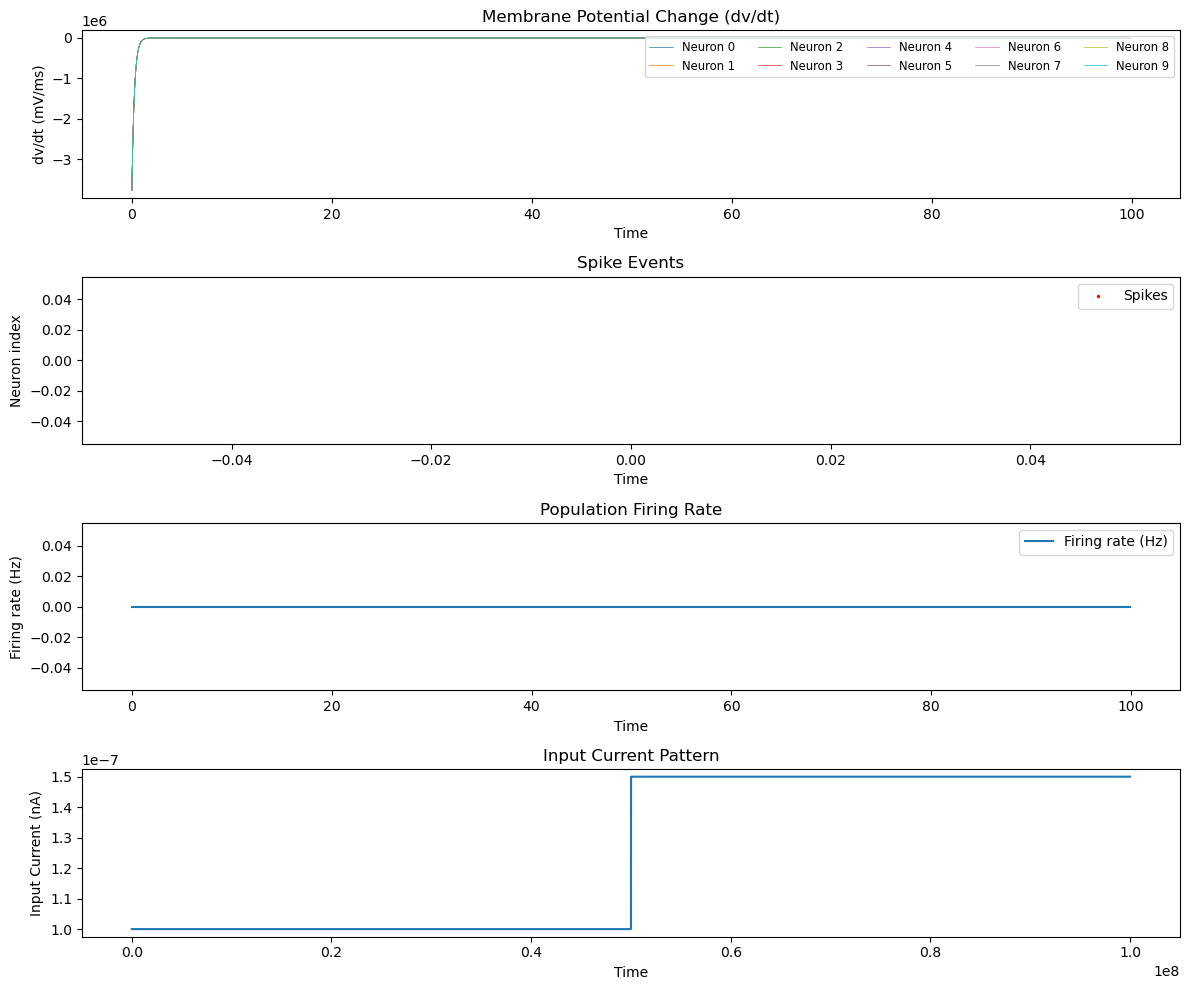

In [9]:
### Set 2
# add cortex input (초기 I: 100 * nA)

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

I_base = 100 * nA
I_step = 150 * nA
I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                   I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA
I_pattern = TimedArray(I_pattern_values, dt=defaultclock.dt)

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.01 / br.ms
dSPN.b = -20 / ms
# dSPN.c = -55 * mV
dSPN.d = 91 * mV / ms
dSPN.k = 1
dSPN.vr = -80 * mV
dSPN.vt = -29.7 * mV
dSPN.vpeak = 40 * mV
C = 15.2 * pF
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5
dSPN.run_regularly('I = I_pattern(t)', dt=defaultclock.dt)

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

plt.figure(figsize=(12, 10))

# Membrane potential change (dv/dt)
plt.subplot(4, 1, 1)
for i in range(10):  # Plotting dv/dt for first 10 neurons
    dv_dt = np.diff(dv_monitor.v[i]) / (dv_monitor.t[1] - dv_monitor.t[0])
    plt.plot(dv_monitor.t[:-1] / ms, dv_dt / mV * 1000, lw=0.5)
plt.xlabel('Time')
plt.ylabel('dv/dt (mV/ms)')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)

# Plot spikes
plt.subplot(4, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

# Plot input current pattern
plt.subplot(4, 1, 4)
input_times = np.arange(len(I_pattern_values)) * defaultclock.dt / ms
plt.plot(input_times, I_pattern_values / nA)
plt.xlabel('Time')
plt.ylabel('Input Current (nA)')
plt.title('Input Current Pattern')

plt.tight_layout()
plt.show()

In [51]:
# Set parameters (Set2)
start_scope()

I_values = np.arange(0, 500, 100) * nA  # Adjust start, end, and step size

all_dv_monitor = []
all_dv_dt = []
all_spike_monitor = []
all_rate_monitor = []


for I_val in I_values:
  dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')
  dSPN.v = -80 * mV
  dSPN.u = 0 * mV / ms
  dSPN.a = 0.01 / br.ms
  dSPN.b = -20 / ms
  dSPN.c = -55 * mV
  dSPN.d = 91 * mV / ms
  dSPN.k = 1
  dSPN.vr = -80 * mV
  dSPN.vt = -29.7 * mV
  dSPN.vpeak = 40 * mV
  C = 15.2 * pF
  # dSPN.I = 10 * nA
  dSPN.Dop1 = 0.5
  dSPN.Dop2 = 0.5

  dv_monitor = StateMonitor(dSPN, variables='v', record=True)
  spike_monitor = SpikeMonitor(dSPN)
  rate_monitor = PopulationRateMonitor(dSPN)  # Adjust bin size as needed

  # Create a new Network instance for each I value
  net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)

  # Set the I value for the current simulation
  dSPN.I = I_val

  # Run the simulation
  net.run(simulation_time)

  # Extract and store results
  dv_dt = np.diff(dv_monitor.v[0]) / (dv_monitor.t[1] - dv_monitor.t[0])
  all_dv_monitor.append(dv_monitor)
  all_dv_dt.append(dv_dt)
  all_spike_monitor.append(spike_monitor)
  all_rate_monitor.append(rate_monitor.smooth_rate(width=10*ms) / Hz)

INFO:root:building '_cython_magic_b53d3bf82ea7517e80eff954d35348fa' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_b53d3bf82ea7517e80eff954d35348fa.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_b53d3bf82ea7517e80eff954d35348fa.o -w

In [ ]:
# Set parameters
start_scope()

v_values = np.arange(-80, 0, 20) * mV  # Adjust start, end, and step size

all_dv_monitor = []
all_dv_dt = []
all_spike_monitor = []
all_rate_monitor = []


for v_val in v_values:
  dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')
  dSPN.v = v_val
  dSPN.u = 0 * mV / ms
  dSPN.a = 0.01 / br.ms
  dSPN.b = -20 / ms
  dSPN.c = -55 * mV
  dSPN.d = 91 * mV / ms
  dSPN.k = 1
  dSPN.vr = -80 * mV
  dSPN.vt = -29.7 * mV
  dSPN.vpeak = 40 * mV
  C = 15.2 * pF
  # dSPN.I = 10 * nA
  dSPN.Dop1 = 0.5
  dSPN.Dop2 = 0.5

  dv_monitor = StateMonitor(dSPN, variables='v', record=True)
  spike_monitor = SpikeMonitor(dSPN)
  rate_monitor = PopulationRateMonitor(dSPN)  # Adjust bin size as needed

  # Create a new Network instance for each I value
  net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)

  # Set the I value for the current simulation
  dSPN.I = 10 * nA

  # Run the simulation
  net.run(simulation_time)

  # Extract and store results
  dv_dt = np.diff(dv_monitor.v[0]) / (dv_monitor.t[1] - dv_monitor.t[0])
  all_dv_monitor.append(dv_monitor)
  all_dv_dt.append(dv_dt)
  all_spike_monitor.append(spike_monitor)
  all_rate_monitor.append(rate_monitor.smooth_rate(width=10*ms) / Hz)

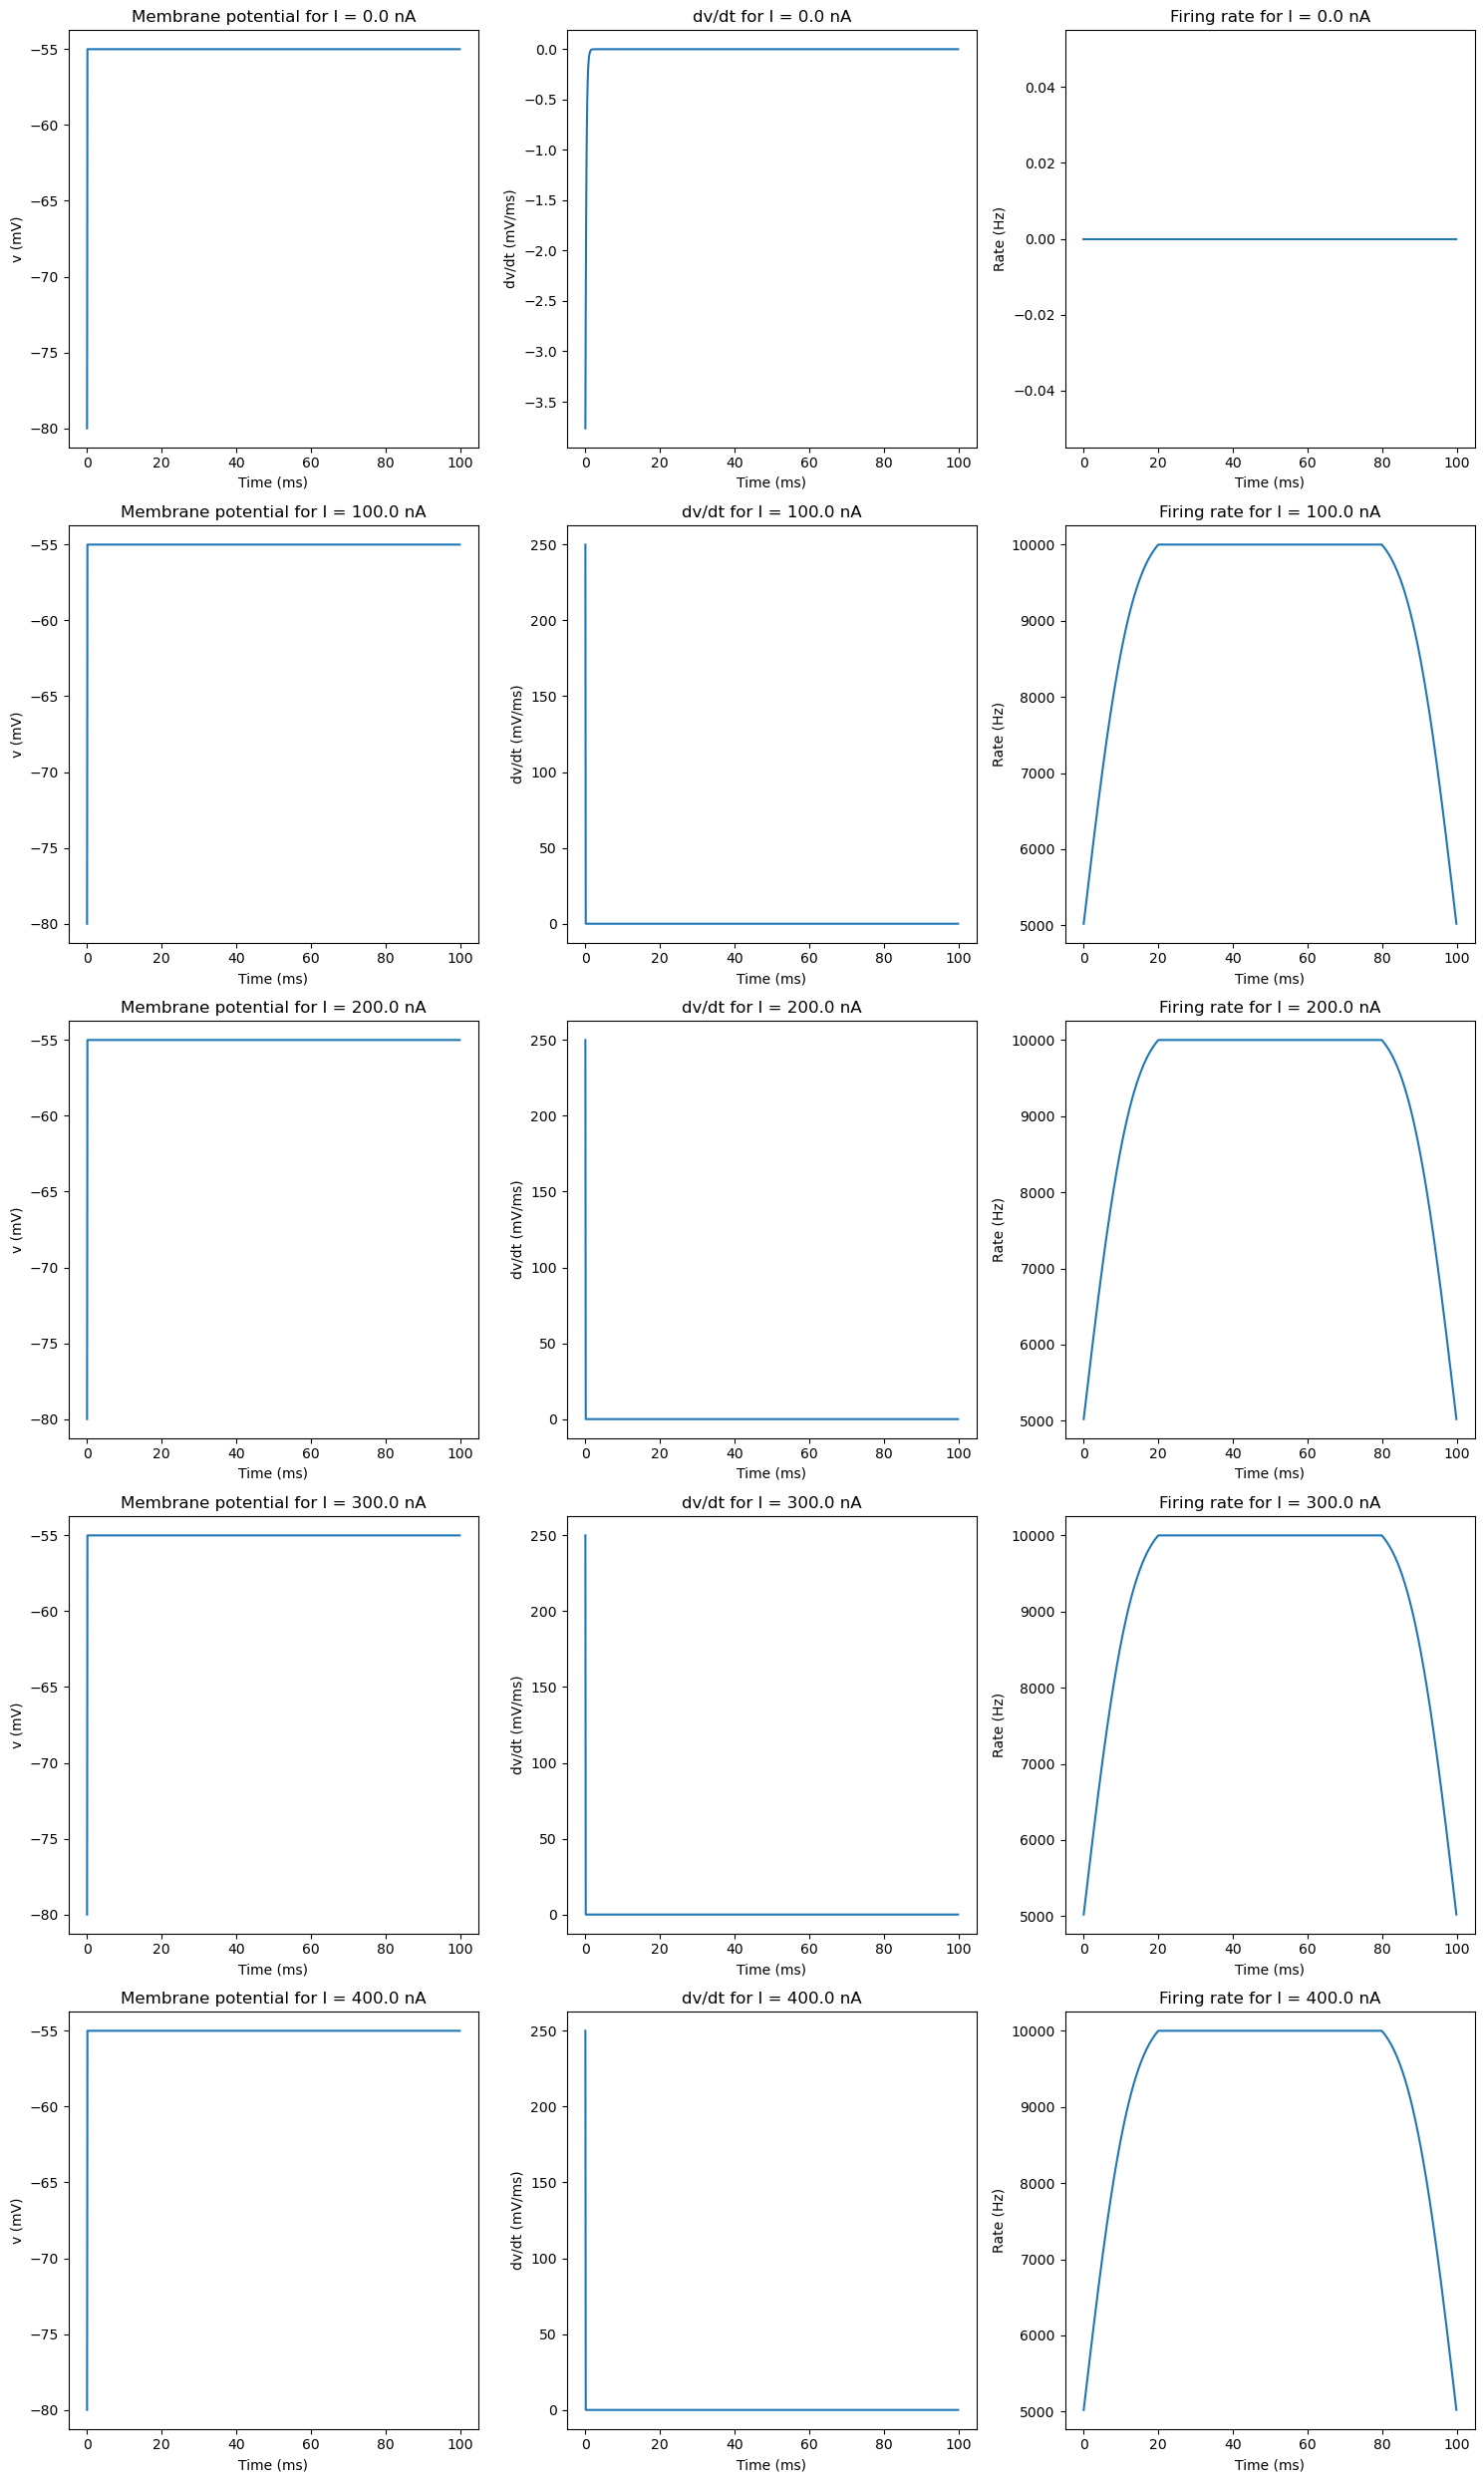

In [52]:
# Visualization (I)
fig, axs = plt.subplots(len(I_values), 3, figsize=(15, len(I_values)*5))

for idx, I_val in enumerate(I_values):
    axs[idx, 0].plot(dv_monitor.t / ms, dv_monitor.v[0] / mV)
    axs[idx, 0].set_title(f'Membrane potential for I = {I_val/nA} nA')
    axs[idx, 0].set_xlabel('Time')
    axs[idx, 0].set_ylabel('v (mV)')
    
    axs[idx, 1].plot(dv_monitor.t[:-1] / ms, all_dv_dt[idx] / (mV / ms))
    axs[idx, 1].set_title(f'dv/dt for I = {I_val/nA} nA')
    axs[idx, 1].set_xlabel('Time')
    axs[idx, 1].set_ylabel('dv/dt (mV/ms)')
    
    axs[idx, 2].plot(rate_monitor.t / ms, all_rate_monitor[idx])
    axs[idx, 2].set_title(f'Firing rate for I = {I_val/nA} nA')
    axs[idx, 2].set_xlabel('Time')
    axs[idx, 2].set_ylabel('Rate (Hz)')

plt.tight_layout()
plt.show()

WARNING    't' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.997e+03, 9.998e+03,
       9.999e+03]) * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO:root:building '_cython_magic_b940c028a7087b55936ba387184e7aa6' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaco

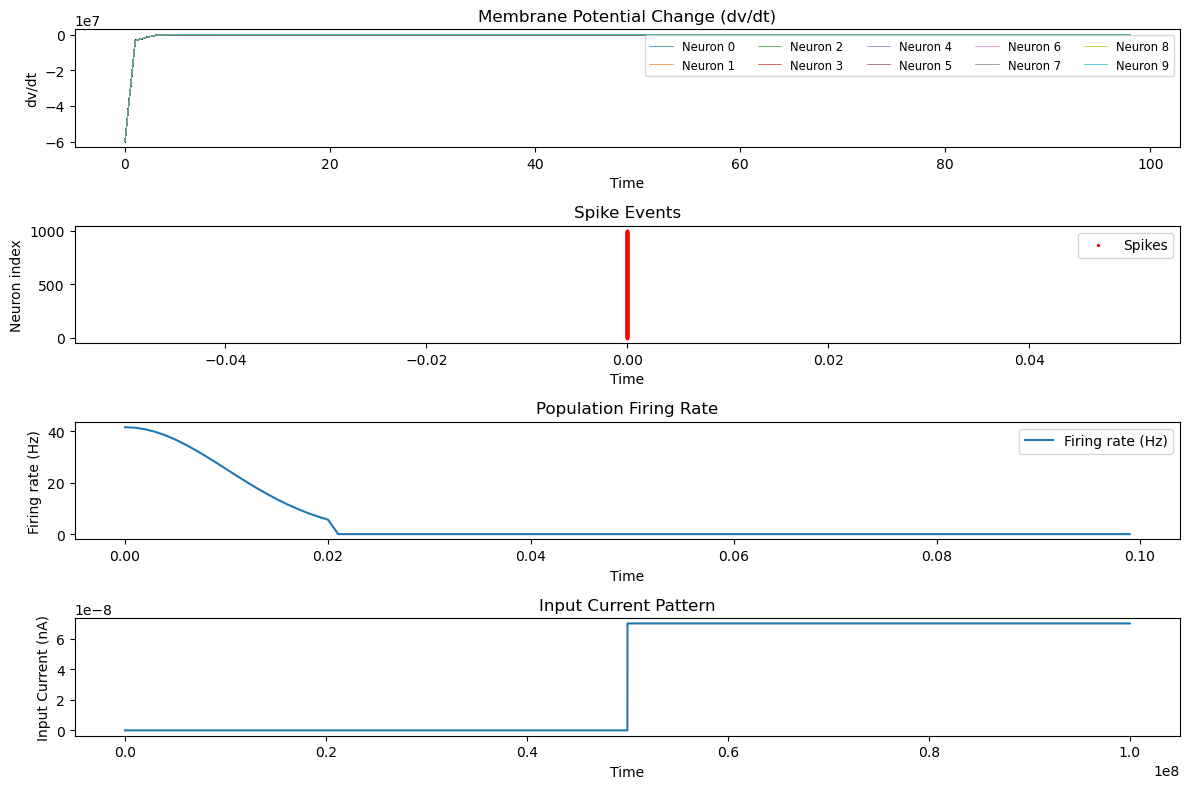

In [22]:
### Set 3: Quantifying harmony between direct and indirect pathways in the basal ganglia: healthy and Parkinsonian states
# add cortex input 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

# dSPN.run_regularly('v = rand()', dt = 1 * ms)
# Create input pattern: constant then step change
I_base = 0 * nA
I_step = 70 * nA
I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                   I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA
I_pattern = TimedArray(I_pattern_values, dt=defaultclock.dt)

dSPN.v = 0 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / br.ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5
dSPN.run_regularly('I = I_pattern(t)', dt=defaultclock.dt)

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(4, 1, 2)
plt.scatter(spike_monitor.t, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

# Plot input current pattern
plt.subplot(4, 1, 4)
input_times = np.arange(len(I_pattern_values)) * defaultclock.dt / ms
plt.plot(input_times, I_pattern_values / nA)
plt.xlabel('Time')
plt.ylabel('Input Current (nA)')
plt.title('Input Current Pattern')

plt.tight_layout()
plt.show()